 # <span style="color:royalblue">HOTEL REVIEW ANALYSIS 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import spacy
import string
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler, ADASYN, BorderlineSMOTE
from imblearn.under_sampling  import RandomUnderSampler,AllKNN,NearMiss, TomekLinks
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense
from keras.models import Sequential
import lightgbm as lgb
from lightgbm import LGBMClassifier
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import joblib
from imblearn.metrics import classification_report_imbalanced
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import nltk
from nltk import tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('vader_lexicon')
#nltk.download('all')
import warnings
warnings.filterwarnings("ignore")

In [2]:
#reading the dataset
data = pd.read_excel("hotel_reviews (1).xlsx")
data.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


# <span style="color:red">EDA

In [3]:
#examining the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


*<span style="color:orange">Inferences: There are 20491 rows and 2 columns. The data types assigned are correct.*

In [4]:
#basic stats of the dataset
data.describe()

,Rating
count,20491.000000
mean,3.952223
std,1.233030
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


*<span style="color:orange">Inferences:*   
*<span style="color:orange">There are 20941 ratings in my dataset*  
*<span style="color:orange">The average rating is 3.95*    
*<span style="color:orange">The ratings vary by approximately 1.23 on average from the mean*    
*<span style="color:orange">The lowest rating is 1.0 and the highest rating is 5.0*   
*<span style="color:orange">25% of the ratings are below 3.0, 50% are below 4.0, and 75% are below 5.0*

In [5]:
#checking for duplicated rows
data[data.duplicated()]

,Review,Rating


*<span style="color:orange">There are no duplicated records.*

In [6]:
#checking for null values
data.isnull().sum()

Review    0
Rating    0
dtype: int64

*<span style="color:orange">There are no null values in any column.*

In [7]:
#counts of distinct values in 'Ratings' feature
data.Rating.value_counts()

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

<Axes: xlabel='Rating', ylabel='count'>

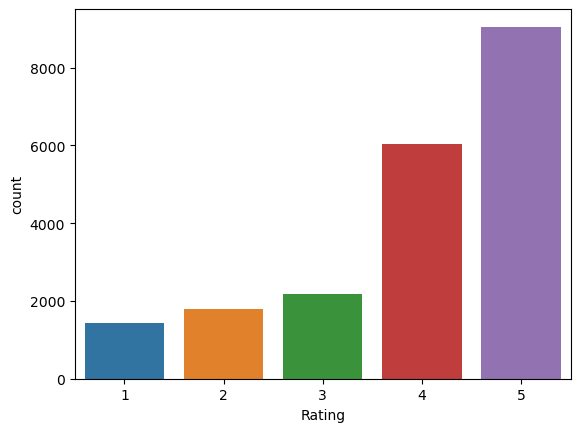

In [8]:
#countplot of the ratings
sns.countplot(x = data.Rating)

*<span style="color:orange">Inferences:*  
    
*<span style="color:orange">There are 4 distinct values in 'Ratings' feature namely, 1,2,3,4,5*
    
*<span style="color:orange">Most ratings are concentrated around 4 and 5*
    
*<span style="color:orange">Ratings of 1 and 2 are the least common*

In [9]:
data = [t.strip() for t in data.Review] #remove both the leading and the trailing characters
data = [x for x in data if x] #removes empty strings because they are considered in Python as False
data[0:2]

['nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,',
 'ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, start booked suite paid extra website description not, suite bedroom bathroom standard hotel room, took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast, got kidding, embassy suits sitting room bathroom bedroom unli

In [10]:
#joining the list into one string/text
text = ' '.join(data)
text[0:100]

'nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice '

In [11]:
#removing punctuations
no_punc_text = text.translate(str.maketrans('', '', string.punctuation)) 
print(no_punc_text[0:100])

nice hotel expensive parking got good deal stay hotel anniversary arrived late evening took advice p


In [12]:
#tokenization 
text_tokens = word_tokenize(no_punc_text)
print(text_tokens[0:10])

['nice', 'hotel', 'expensive', 'parking', 'got', 'good', 'deal', 'stay', 'hotel', 'anniversary']


In [13]:
#removing stopwords
my_stop_words = stopwords.words('english')
no_stop_tokens = [word for word in text_tokens if not word in my_stop_words]
print(no_stop_tokens[0:10])

['nice', 'hotel', 'expensive', 'parking', 'got', 'good', 'deal', 'stay', 'hotel', 'anniversary']


In [14]:
#normalizing the text (converting into lowercase)
lower_words = [x.lower() for x in no_stop_tokens]
print(lower_words[0:10])

['nice', 'hotel', 'expensive', 'parking', 'got', 'good', 'deal', 'stay', 'hotel', 'anniversary']


In [15]:
#applying NLP
nlp = spacy.load('en_core_web_sm') 
nlp.max_length = 14840515
doc_text=' '.join(no_stop_tokens)
doc = nlp(doc_text)

In [16]:
#lemmatization
#lemmas = [word.lemma_ for word in doc]
#print(lemmas[0:10])

In [17]:
#user-defined function to plot word cloud
def plot_cloud(wordcloud):
    plt.figure(figsize=(40, 30))
    plt.imshow(wordcloud) 
    plt.axis("off");

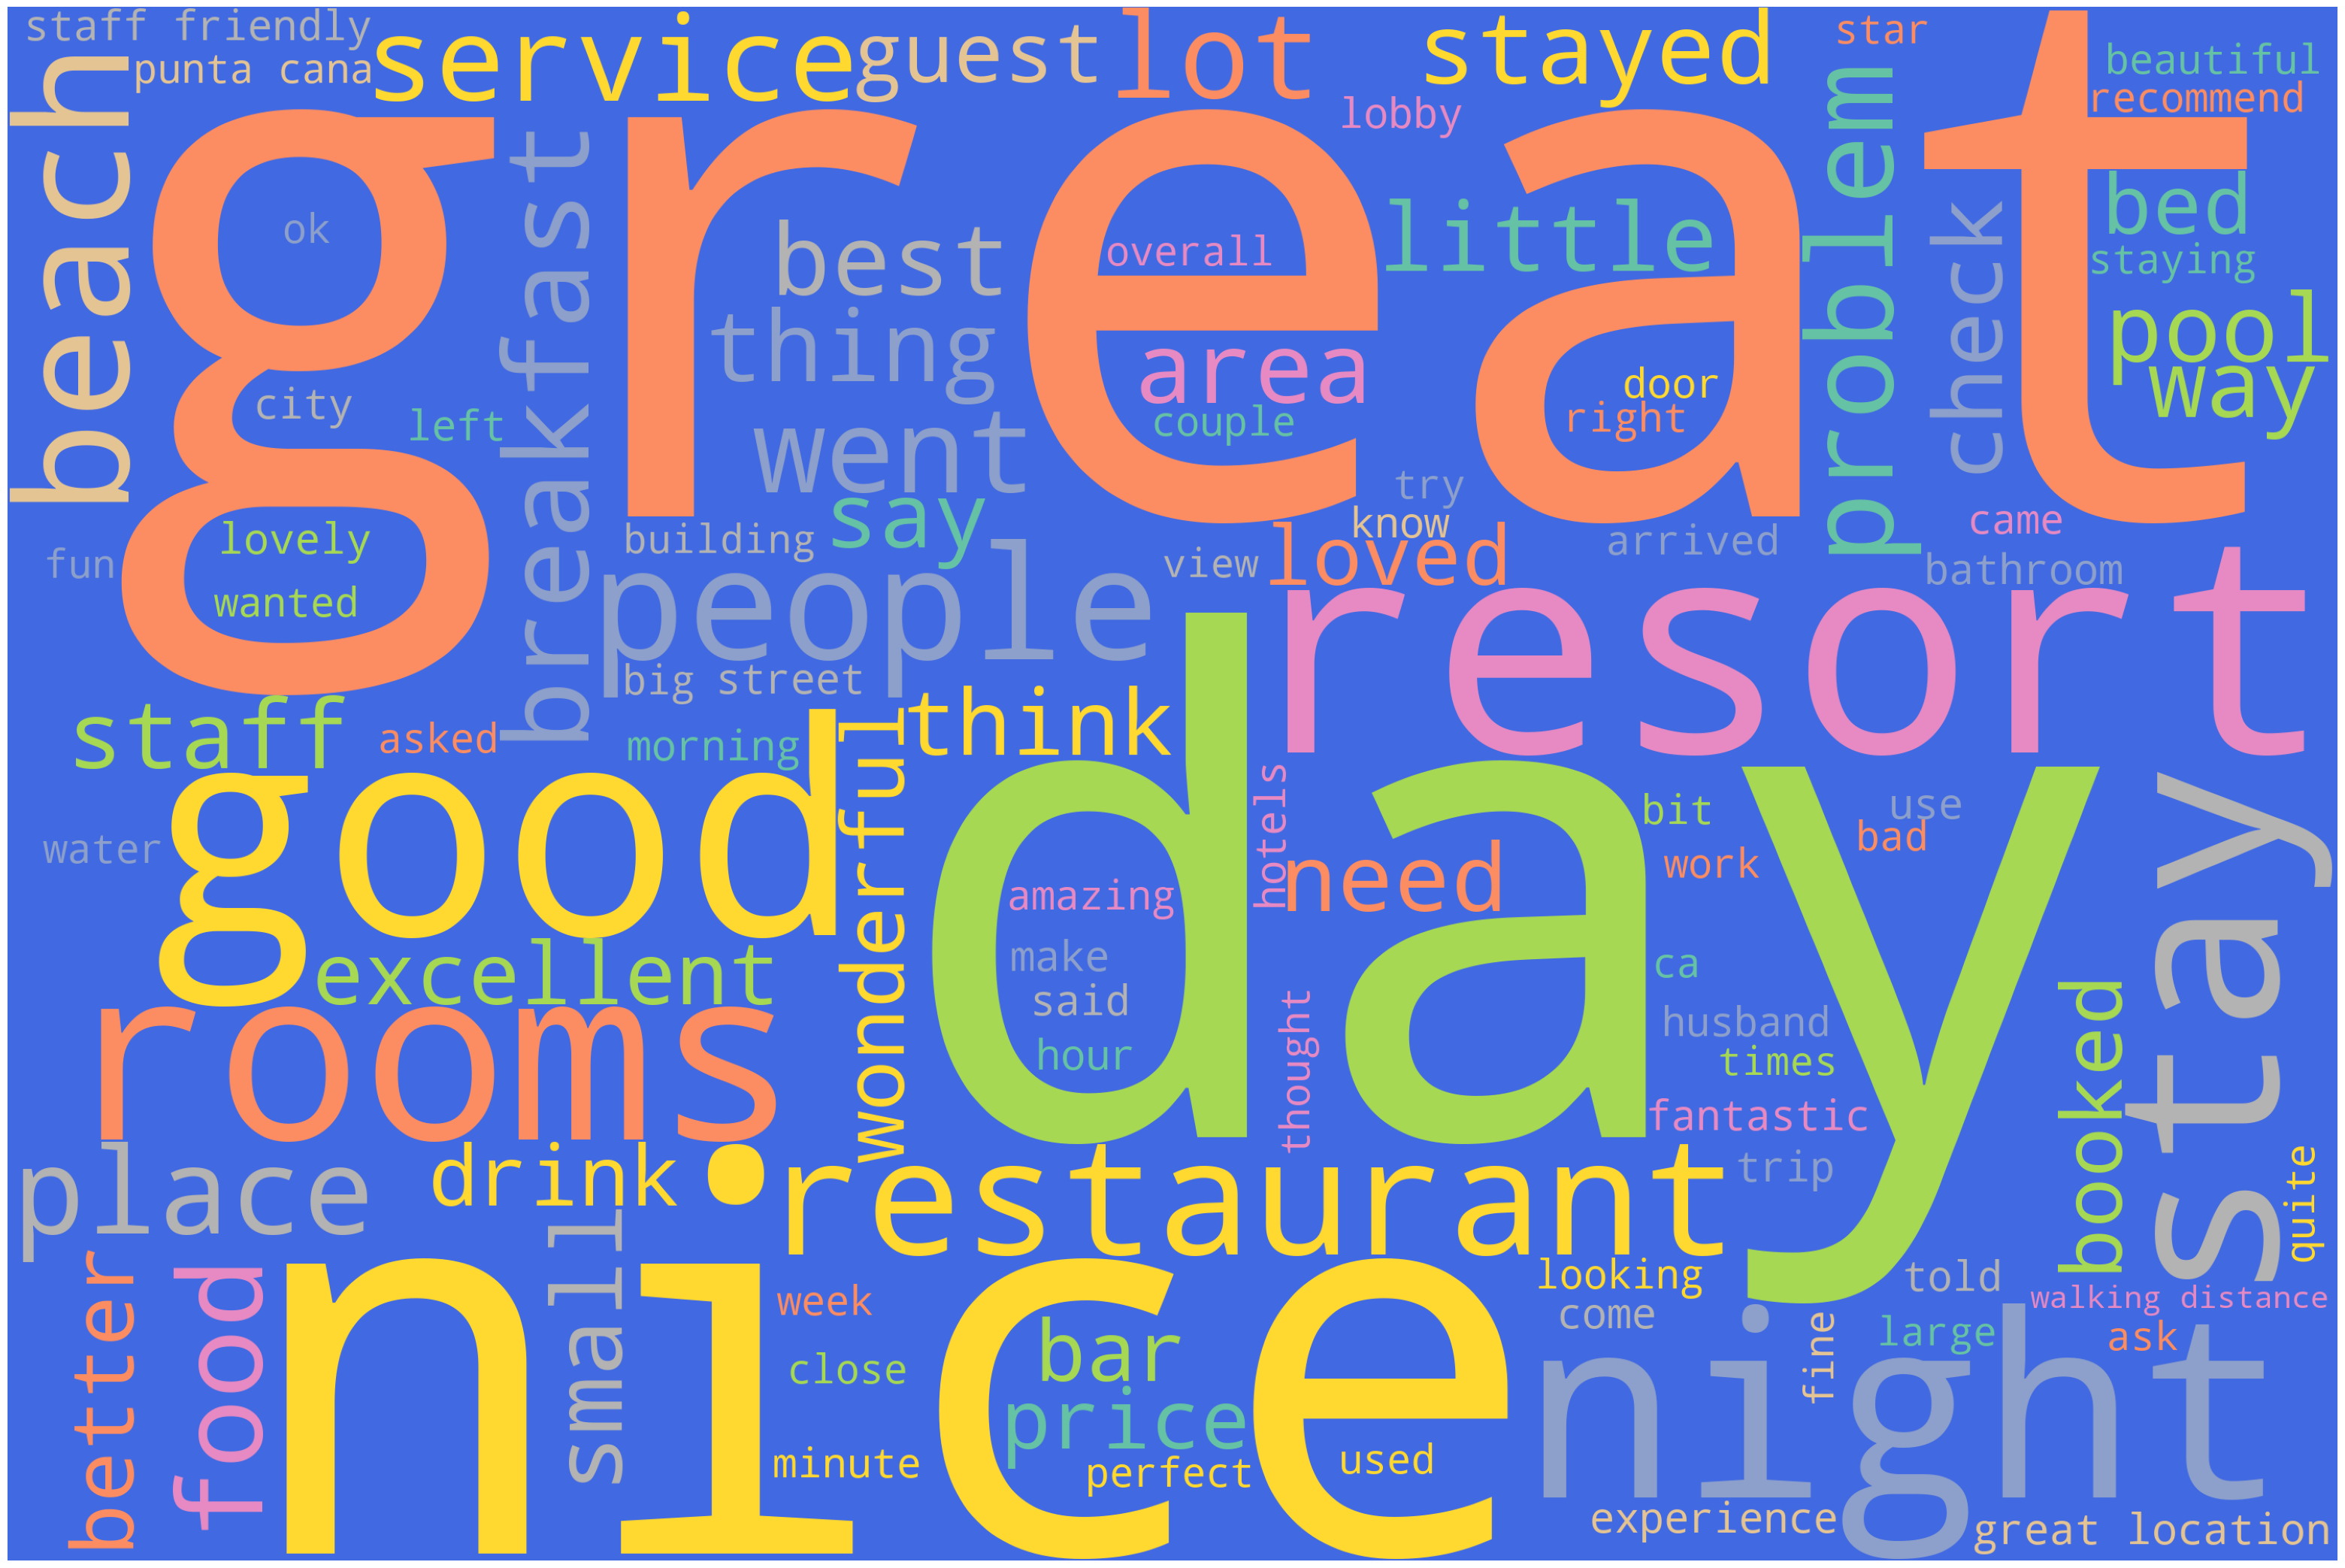

In [18]:
# generating wordcloud
stopwords = STOPWORDS
stopwords.add('hotel')
stopwords.add('room')
stopwords.add('really')
stopwords.add('time')
stopwords.add('got')
stopwords.add('going')
stopwords.add('want')
stopwords.add('took')
stopwords.add('look')
stopwords.add("n't")

wordcloud = WordCloud(width = 3000, height = 2000, background_color='royalblue',colormap='Set2',max_words=100,stopwords=stopwords).generate(text)
plot_cloud(wordcloud)

*<span style="color:orange">Inferences: Some of the key words noticed are great, nice, day, wonderful, problem, beautiful, big, small, excellent, fantastic, fine, best....*   

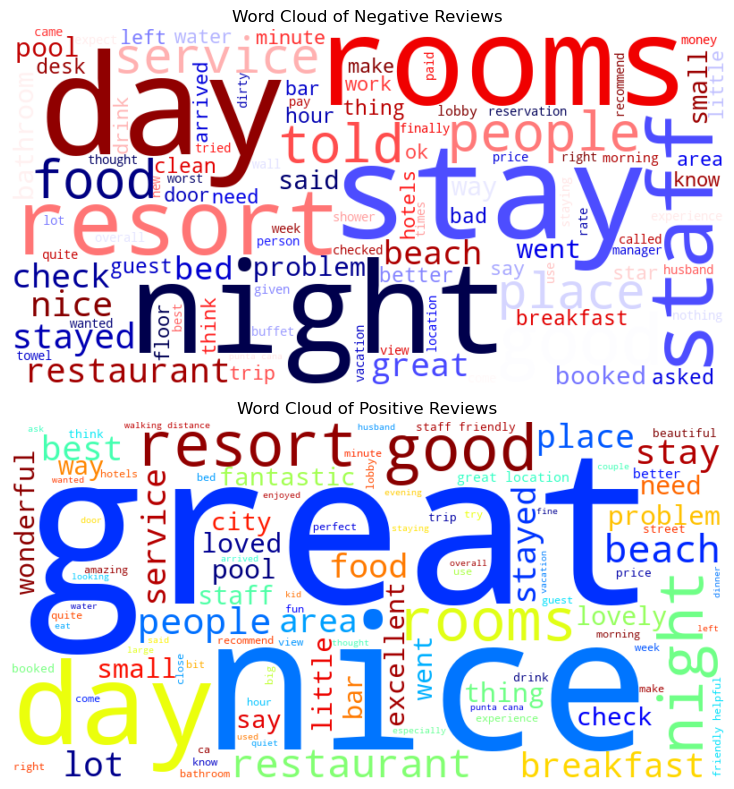

In [19]:
df = pd.read_excel('hotel_reviews (1).xlsx')
#filter out negative reviews
negative_reviews = df[df['Rating'].isin([1,2])]['Review']
#filter out positive reviews
positive_reviews = df[df['Rating'].isin([4,5])]['Review']

fig,(ax1, ax2) = plt.subplots(2,1, figsize=(16,8))
stopwords = STOPWORDS
stopwords.add('hotel')
stopwords.add('room')
stopwords.add('really')
stopwords.add('time')
stopwords.add('got')
stopwords.add('going')
stopwords.add('want')
stopwords.add('took')
stopwords.add('look')
stopwords.add("n't")

#generating the word cloud for negative reviews
negative_wordcloud = WordCloud(width=800, height=400,max_words=100,stopwords=stopwords,
                               background_color='white',colormap='seismic').generate(' ' .join(negative_reviews))
ax1.imshow(negative_wordcloud, interpolation='bilinear')
ax1.set_title('Word Cloud of Negative Reviews')
ax1.axis('off')

#generating the word cloud for positive reviews
positive_wordcloud = WordCloud(width=800, height=400,max_words=100,stopwords=stopwords,
                               background_color='white',colormap='jet_r',).generate(' '.join(positive_reviews))
ax2.imshow(positive_wordcloud, interpolation='bilinear')
ax2.set_title('Word Cloud of Positive Reviews')
ax2.axis('off')
plt.tight_layout()
plt.show()

*<span style="color:orange">Inferences: Some of the key words noticed in negative rated word clouds are problem, ok, small, worst, bad, overall, little....*
    
*<span style="color:orange">Inferences: Some of the key words noticed positive rated word clouds are great, nice, good, day, excellent, loved, fantastic, best....*  

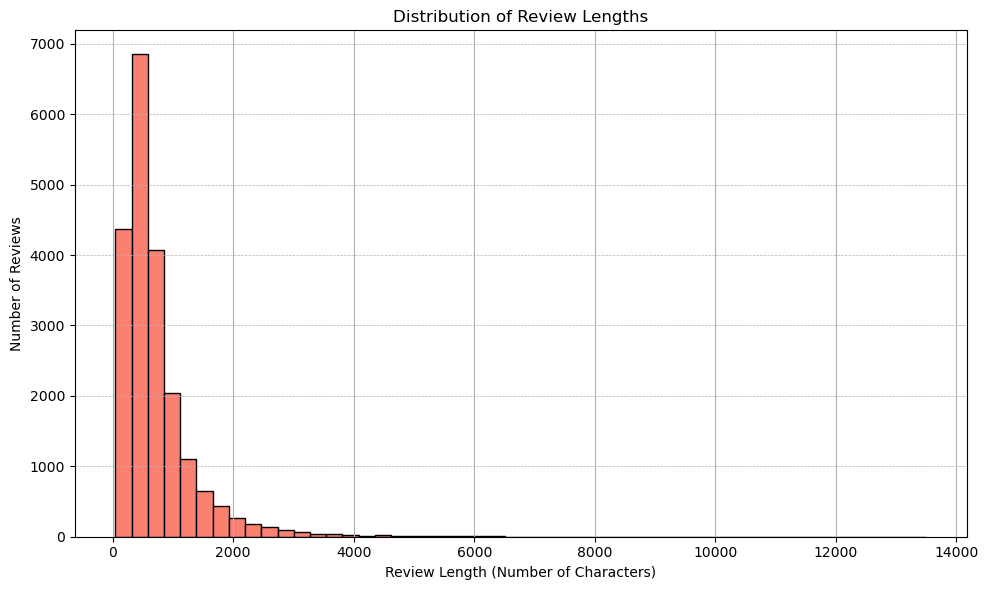

Average Review Length: 725.245571226392


In [20]:
#distribution of the length of the reviews
df['Review_Length'] = df['Review'].apply(len)

plt.figure(figsize=(10,6))
df['Review_Length'].hist(bins=50, color='salmon', edgecolor='black')
plt.title('Distribution of Review Lengths') 
plt.xlabel('Review Length (Number of Characters)')
plt.ylabel('Number of Reviews')
plt.grid(axis='y', linestyle='--', linewidth=0.5) 
plt.tight_layout()

#average review length(no. of characters)
average_review_length = df['Review_Length'].mean()
plt.show()
print("Average Review Length:",average_review_length)

*<span style="color:orange">Inferences:*
    
*<span style="color:orange">According to the histogram showing the distribution of the length of the reviews, we see that many reviews are in the range of 0–2000 characters.*
    
*<span style="color:orange">There are fewer reviews with very long lengths. Concise reviews rather than lengthy reviews.*
    
*<span style="color:orange">The average review length is approximately 725 characters.*

In [21]:
#Tfidf Vectorizer (unigram model)
vectorizer_n_gram_max_features = TfidfVectorizer(analyzer='word', ngram_range=(1,1), max_features = 200)
tf_idf_matrix_n_gram_max_features = vectorizer_n_gram_max_features.fit_transform(data)
#print(vectorizer_n_gram_max_features.get_feature_names_out())
print(tf_idf_matrix_n_gram_max_features.toarray())

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.10363432 0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.03601036 0.         0.         ... 0.04218387 0.         0.1268829 ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


*<span style="color:orange">This vectorization process involves converting each document (or text sample) into a vector where each dimension represents a unique term (or feature) in the corpus, and the value of each dimension indicates the importance of that term within the document.*

In [ ]:
#Parts of Speech (POS) refer to the grammatical categories to which words belong in a particular language
for token in doc:
    print(token, token.pos_)

*<span style="color:orange">Noun(NOUN), Verb(VERB), Adjective(ADJ), Adverb(ADV), Pronoun(PRON), Preposition(PREP),Conjunction (CONJ), Interjection(INTJ)*

In [23]:
#filtering the nouns and verbs
nouns_verbs = [token.text for token in doc if token.pos_ in ('NOUN', 'VERB')]
print(nouns_verbs[0:10])

['hotel', 'parking', 'got', 'deal', 'stay', 'hotel', 'anniversary', 'arrived', 'evening', 'took']


In [24]:
#Count Vectorizer (unigram model) on nouns and verbs
cv = CountVectorizer()
X = cv.fit_transform(nouns_verbs)

In [25]:
#dataframe for the counts of nouns and verbs
sum_words = X.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
wf_df = pd.DataFrame(words_freq)
wf_df.columns = ['word', 'count']
wf_df.head(10)

,word,count
0,hotel,43551
1,room,34244
2,staff,15500
3,stay,15029
4,rooms,11993
5,location,10826
6,stayed,10360
7,time,9757
8,service,9669
9,night,9338


<Axes: title={'center': 'Top 10 verbs and nouns'}, xlabel='word'>

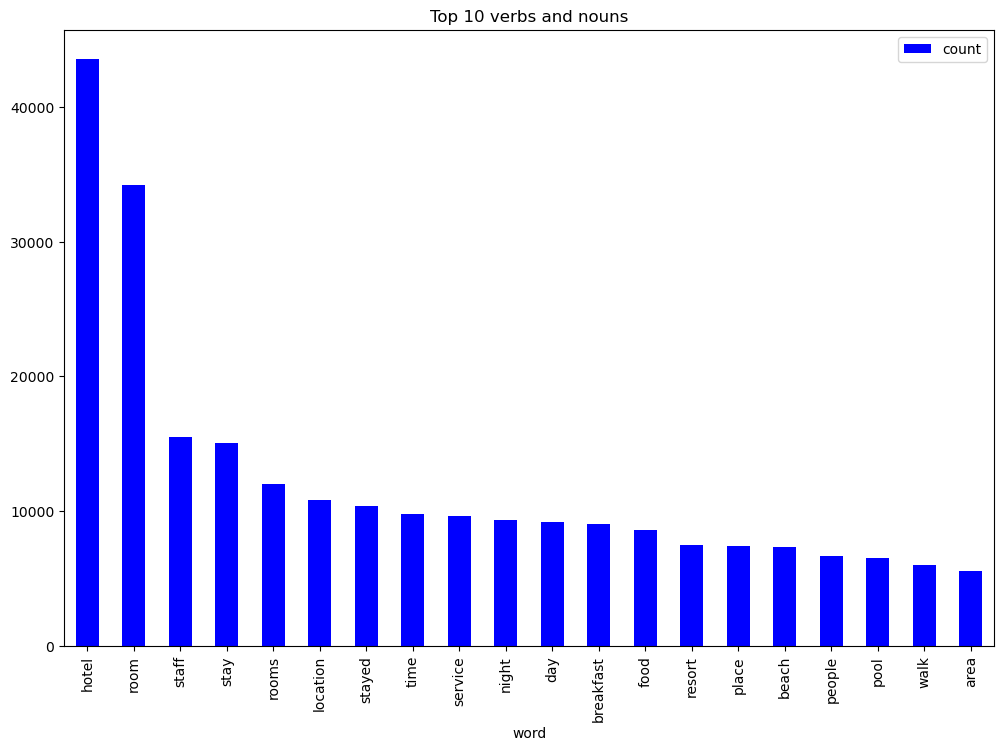

In [26]:
#plotting the top 20 nouns and verbs
wf_df[0:20].plot.bar(x='word', figsize=(12,8), title='Top 10 verbs and nouns',color='blue')

*<span style="color:orange">Inferences: This plot gives a clear idea of the prominent entities, objects, or concepts mentioned in the reviews. Moreover, it highlights the main actions, processes, or events described in the reviews.*

In [27]:
#filtering the adjectives
adj = [token.text for token in doc if token.pos_ in ('ADJ')]
print(adj[0:10])

['nice', 'expensive', 'good', 'late', 'previous', 'quick', 'easy', 'little', 'disappointed', 'nonexistent']


In [28]:
#Count Vectorizer (unigram model) on adjectives
X1 = cv.fit_transform(adj)

In [29]:
#dataframe for the counts of nouns and verbs
sum_wrds = X1.sum(axis=0)
wrd_freq = [(word, sum_wrds[0, idx]) for word, idx in cv.vocabulary_.items()]
wrd_freq =sorted(wrd_freq, key = lambda x: x[1], reverse=True)
wf = pd.DataFrame(wrd_freq)
wf.columns = ['adjective', 'count']
wf.head()

,adjective,count
0,great,20406
1,good,16185
2,nice,11791
3,clean,8419
4,small,6316


<Axes: title={'center': 'Top 20 Adjectives'}, xlabel='adjective'>

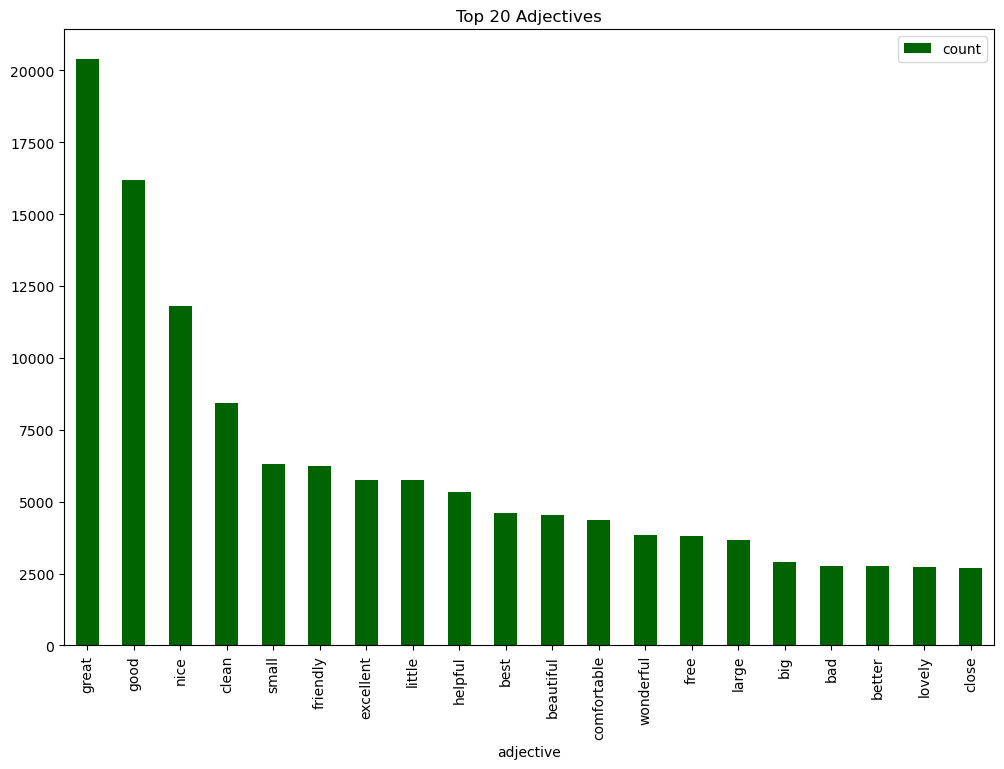

In [30]:
#plotting the top 20 adjectives
wf[0:20].plot.bar(x='adjective', figsize=(12,8), title='Top 20 Adjectives',color='darkgreen')

*<span style="color:orange">Inferences: We are visualizing the occurrence of the most common adjectives in our dataset. By analyzing the top adjectives, we can gain insights into the characteristics, qualities, or sentiments associated with the reviews in the dataset.*

In [31]:
#CountVectorizer (Bi-gram model)
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2), max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [32]:
#top 100 words from bigram model
top2_words = get_top_n2_words(df["Review"], n=100)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Frequency"]
top2_df

,Bi-gram,Frequency
0,did not,3773
1,great location,2203
2,staff friendly,2116
3,punta cana,1727
4,walking distance,1468
...,...,...
95,continental breakfast,436
96,hong kong,435
97,times square,435
98,breakfast good,434


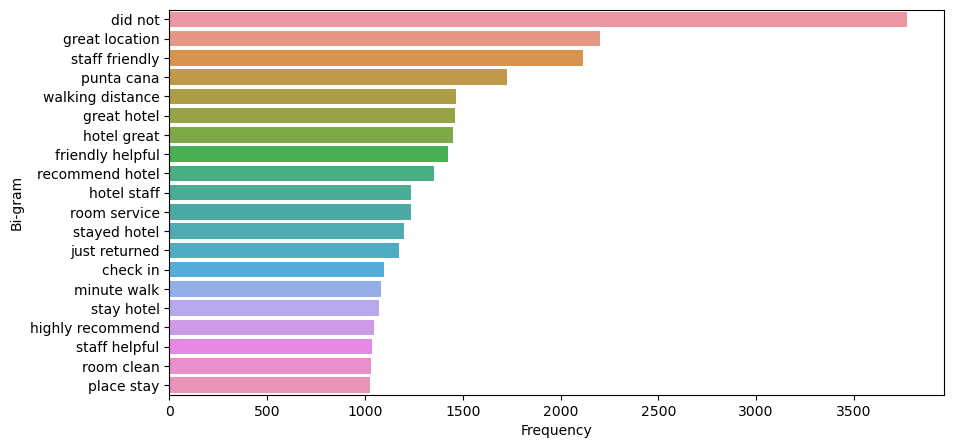

In [33]:
#Bi-gram plot
top20_bigram = top2_df.iloc[0:20,:]
fig = plt.figure(figsize = (10, 5))
plot=sns.barplot(y=top20_bigram["Bi-gram"],x=top20_bigram["Frequency"])
#plot.set_xticklabels(rotation=45,labels = top20_bigram["Bi-gram"])

*<span style="color:orange">Inferences: Analyzing the top 20 bigrams provides insights into the language usage and patterns within the reviews. It helps identify recurring phrases or associations between words that are frequently used together.*

In [34]:
#CountVectorizer (Tri-gram model)
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3),max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1],reverse=True)
    return words_freq[:n]

In [35]:
#top 100 words from bigram model
top3_words = get_top_n3_words(df["Review"], n=100)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Frequency"]
top3_df

,Tri-gram,Frequency
0,staff friendly helpful,767
1,hotel great location,552
2,old san juan,364
3,highly recommend hotel,321
4,great place stay,281
...,...,...
95,short walk away,71
96,walking distance hotel,71
97,friendly helpful room,70
98,great location just,69


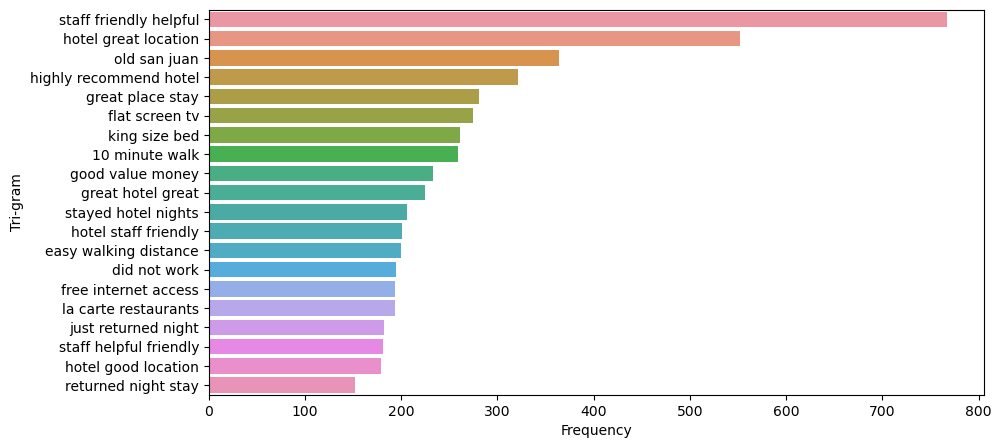

In [36]:
#Tri-gram plot
top20_trigram = top3_df.iloc[0:20,:]
fig = plt.figure(figsize = (10, 5))
plot=sns.barplot(y=top20_trigram["Tri-gram"],x=top20_trigram["Frequency"])
#plot.set_xticklabels(rotation=55,labels = top20_trigram["Tri-gram"])

*<span style="color:orange">Inferences: Analyzing the top 20 trigrams provides insights into the language usage and patterns within the reviews. It helps identify recurring phrases or associations between words that are frequently used together.*

In [37]:
#VADER(Valence Aware Dictionary for Sentiment Reasoning)
sia = SentimentIntensityAnalyzer()

In [38]:
#sentiment analysis on each review
res=[]
for i,row in tqdm(df.iterrows(),total=len(df)):
    text = row['Review']
    res.append(sia.polarity_scores(text))

  0%|          | 0/20491 [00:00<?, ?it/s]

In [39]:
#displaying the positive, neutral, negative and compound sentiment scores of the reviews
vaders = pd.DataFrame(res)
vaders = vaders.join(df)
vaders

,neg,neu,pos,compound,Review,Rating,Review_Length
0,0.072,0.643,0.285,0.9747,nice hotel expensive parking got good deal sta...,4,593
1,0.110,0.701,0.189,0.9787,ok nothing special charge diamond member hilto...,2,1689
2,0.081,0.700,0.219,0.9889,nice rooms not 4* experience hotel monaco seat...,3,1427
3,0.060,0.555,0.385,0.9912,"unique, great stay, wonderful time hotel monac...",5,600
4,0.135,0.643,0.221,0.9797,"great stay great stay, went seahawk game aweso...",5,1281
...,...,...,...,...,...,...,...
20486,0.063,0.665,0.272,0.9834,"best kept secret 3rd time staying charm, not 5...",5,733
20487,0.000,0.570,0.430,0.9753,great location price view hotel great quick pl...,4,306
20488,0.131,0.724,0.145,0.2629,"ok just looks nice modern outside, desk staff ...",2,443
20489,0.150,0.671,0.179,0.9867,hotel theft ruined vacation hotel opened sept ...,1,5557


*<span style="color:orange">VADER considers both the polarity (positive, negative, or neutral) and the intensity of sentiment expressed in a text. It calculates a compound sentiment score, which is a normalized, weighted composite score that ranges from -1 (extremely negative) to +1 (extremely positive). This score reflects the overall sentiment expressed in the text.*

<Axes: xlabel='Rating', ylabel='compound'>

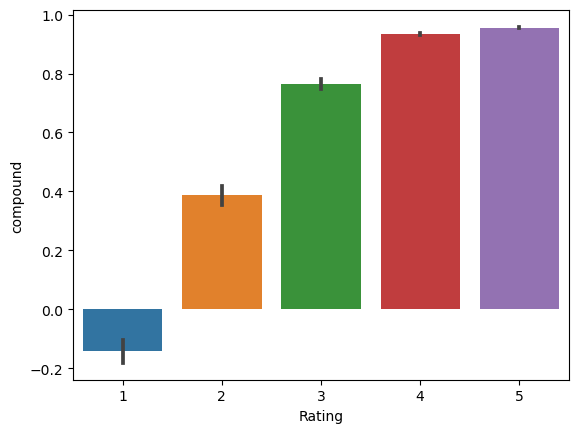

In [40]:
#plotting relationship between rating and sentiment scores
sns.barplot(data=vaders, x='Rating', y='compound')

*<span style="color:orange">Inferences: This plot displays positive correlation between compound sentiment scores and ratings suggesting that customers' sentiment expressions align with their numerical evaluations of hotels.*

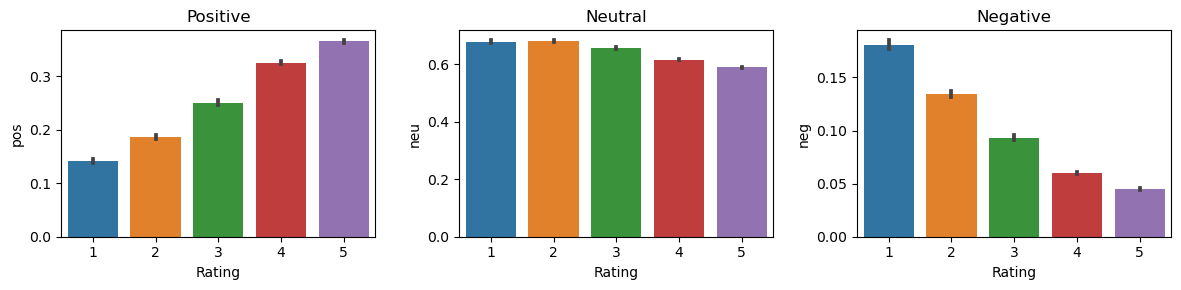

In [41]:
fig, axs = plt.subplots(1,3, figsize=(12,3))
sns.barplot(data=vaders, x='Rating', y='pos',ax=axs[0]) #relationship between rating and positive sentiment score
sns.barplot(data=vaders, x='Rating', y='neu',ax=axs[1]) #relationship between rating and neutral sentiment score
sns.barplot(data=vaders, x='Rating', y='neg',ax=axs[2]) #relationship between rating and negative sentiment score
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

*<span style="color:orange">Inferences:*
    
*<span style="color:orange">The fact that higher ratings are associated with higher positive sentiment scores indicates that customers tend to express more positive sentiment in their reviews when they give higher ratings.*
    
*<span style="color:orange">Customers may express neutral sentiment when their experiences are neither exceptionally positive nor negative. As a result, the neutral sentiment score is relatively stable across different ratings.*
    
*<span style="color:orange">As ratings increase, the level of negative sentiment expressed in the reviews is decreasing. This alignment indicates that customers who provide higher ratings are less likely to express negative sentiments in their reviews.*

In [42]:
#examining the correlation values between sentiment scores and ratings
vaders.corr()

,neg,neu,pos,compound,Rating,Review_Length
neg,1.000000,0.066181,-0.580584,-0.698525,-0.589088,0.083603
neu,0.066181,1.000000,-0.850831,-0.232990,-0.317196,0.309609
pos,-0.580584,-0.850831,1.000000,0.557968,0.569027,-0.296632
compound,-0.698525,-0.232990,0.557968,1.000000,0.606625,0.057296
Rating,-0.589088,-0.317196,0.569027,0.606625,1.000000,-0.080573
Review_Length,0.083603,0.309609,-0.296632,0.057296,-0.080573,1.000000


*<span style="color:orange">Inferences:*
    
*<span style="color:orange">There is somewhat strong positive correlation between compound sentiment score and ratings.*
    
*<span style="color:orange">There is moderate positive correlation between positive sentiment score and ratings.* 
    
*<span style="color:orange">There is weak negative correlation between neutral sentiment score and ratings.* 
    
*<span style="color:orange">There is moderate negative correlation between negative sentiment score and ratings.*   

<Axes: title={'center': 'Sentiment value against Review Length'}, xlabel='Review_Length', ylabel='compound'>

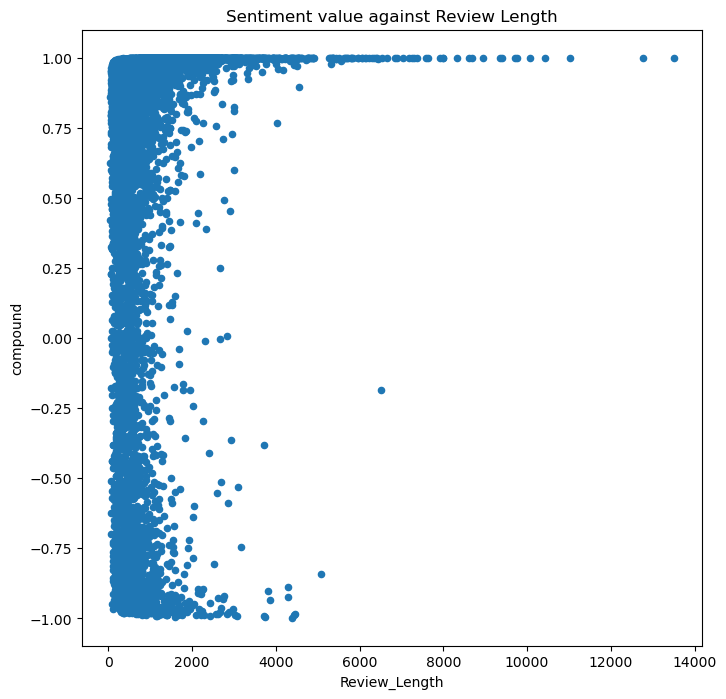

In [52]:
#plotting sentiment value against Review Length
vaders.plot.scatter(x='Review_Length', y='compound', figsize=(8,8), title='Sentiment value against Review Length')

*<span style="color:orange">Inferences:*
    
*<span style="color:orange">Each data point in the scatter plot represents a review, with its position determined by the review length and corresponding sentiment value.*
    
*<span style="color:orange">Longer reviews seem to have higher sentiment values.*
    
*<span style="color:orange">The distribution indicates that the majority of reviews are relatively short, with lengths typically falling within the range of 0 to 2000 characters.*

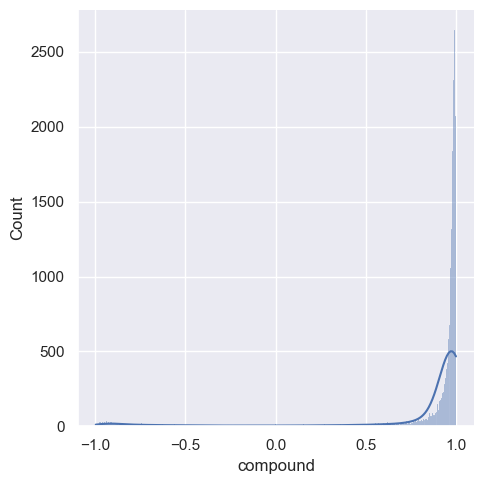

In [65]:
#plotting the compound sentiment score
sns.displot(data=vaders,x='compound',kde=True)
plt.show()

*<span style="color:orange">Inferences: The plot indicates region between 0.85 to 1.00 has high density suggesting that this is where sentiment scores are concentrated. The spread of the plot indicates the variability or dispersion of sentiment scores within our dataset.*

In [45]:
#basic stats of the sentiment scores
vaders.describe()

,neg,neu,pos,compound,Rating,Review_Length
count,20491.000000,20491.000000,20491.000000,20491.000000,20491.000000,20491.000000
mean,0.071909,0.617716,0.310376,0.803430,3.952223,725.245571
std,0.065673,0.101764,0.124714,0.455671,1.233030,689.933070
min,0.000000,0.123000,0.000000,-0.997400,1.000000,44.000000
25%,0.025000,0.556000,0.226000,0.918400,3.000000,339.000000
50%,0.059000,0.625000,0.303000,0.973800,4.000000,537.000000
75%,0.103000,0.687000,0.388000,0.988800,5.000000,859.000000
max,0.646000,1.000000,0.818000,0.999900,5.000000,13501.000000


*<span style="color:orange">Inferences: The average negative sentiment score is 0.07, the average neutral sentiment score is 0.62, the average positive sentiment score is 0.31, the average compound sentiment score is 0.8*   

In [46]:
#labelling the ratings
def sentiment_label(rating):
    if rating in [1, 2]: 
        return 'Negative'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Positive'
df['Sentiment'] = df['Rating'].apply(sentiment_label)
sentiment_distribution = df['Sentiment'].value_counts()
sentiment_distribution

Positive    15093
Negative     3214
Neutral      2184
Name: Sentiment, dtype: int64

([<matplotlib.patches.Wedge at 0x1f140fd65c0>,
 [Text(-0.8796398706644847, 0.9572009705058644, 'Positve'),
  Text(0.43681152922016236, -1.0095522215023567, 'Negative'),
  Text(1.0389086094361348, -0.36148153651255366, 'Neutral')],
 [Text(-0.5413168434858366, 0.589046751080532, '73.7%'),
  Text(0.23826083412008853, -0.5506648480921945, '15.7%'),
  Text(0.5666774233288008, -0.19717174718866562, '10.7%')])

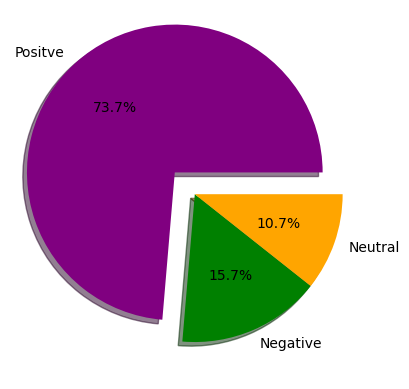

In [47]:
#pie chart of postive, negative and neutral sentiment
plt.pie(df['Sentiment'].value_counts(),labels=['Positve','Negative','Neutral'], 
        explode=[0.2, 0, 0],shadow = True, colors=['purple','green','orange'],autopct='%1.1f%%')

*<span style="color:orange">Inferences: Most of the reviews can be categorized as postive reviews, that is, most reviews have ratings 4 or 5. Moreover, there are more negative reviews compared to neutral reviews.*

In [3]:
#saving the vaders df as excel file 
vaders.to_excel('final.xlsx')
df = pd.read_excel('final.xlsx')

In [6]:
#defining a new column which will serve as label to classify the reviews
def label_classify(compound):
    if compound>0:
        return 'positive'
    elif compound<=0:
        return 'negative'

df['label']= df['compound'].apply(label_classify) 

In [7]:
#dropping the columns which will not be required and renaming needed columns
df.drop(columns=['Unnamed: 0','neg','neu','pos','compound','Rating','Review_Length'],inplace=True)
df.rename({'Review':'review','label':'sentiment'},axis=1,inplace=True)
df

,review,sentiment
0,nice hotel expensive parking got good deal sta...,positive
1,ok nothing special charge diamond member hilto...,positive
2,nice rooms not 4* experience hotel monaco seat...,positive
3,"unique, great stay, wonderful time hotel monac...",positive
4,"great stay great stay, went seahawk game aweso...",positive
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",positive
20487,great location price view hotel great quick pl...,positive
20488,"ok just looks nice modern outside, desk staff ...",positive
20489,hotel theft ruined vacation hotel opened sept ...,positive


In [8]:
#text preprocessing
def preprocess_data(data):
    # Convert text to lowercase
    data['review'] = data['review'].str.strip().str.lower()
    return data
df = preprocess_data(df)

In [10]:
#negative reviews according to compound sentiment score
df[df['sentiment']=='negative']

,review,sentiment
27,met expectations centrally located hotel block...,negative
40,"bad choice, booked hotel hot wire called immed...",negative
42,warwick bad good reviews warwick shocks staff ...,negative
44,"austin powers decor familiar, hotel seattlewhe...",negative
65,"hated inn terrible, room-service horrible staf...",negative
...,...,...
20465,not stay hotel brought group february worst ho...,negative
20467,returning la concha nightmare surprising hotel...,negative
20484,deceptive staff deceptive desk staff claiming ...,negative
20485,not impressed unfriendly staff checked asked h...,negative


In [11]:
#negative reviews according to compound sentiment score
df[df['sentiment']=='positive']

,review,sentiment
0,nice hotel expensive parking got good deal sta...,positive
1,ok nothing special charge diamond member hilto...,positive
2,nice rooms not 4* experience hotel monaco seat...,positive
3,"unique, great stay, wonderful time hotel monac...",positive
4,"great stay great stay, went seahawk game aweso...",positive
...,...,...
20483,good bed clean convenient just night happy sta...,positive
20486,"best kept secret 3rd time staying charm, not 5...",positive
20487,great location price view hotel great quick pl...,positive
20488,"ok just looks nice modern outside, desk staff ...",positive


([<matplotlib.patches.Wedge at 0x21ae9b59090>,
 [Text(-1.0658713276233542, 0.2718792249334775, 'Positve'),
  Text(1.259666137026498, -0.3213117228311781, 'Negative')],
 [Text(-0.5813843605218295, 0.14829775905462408, '92.1%'),
  Text(0.7751791612470758, -0.19773029097303263, '7.9%')])

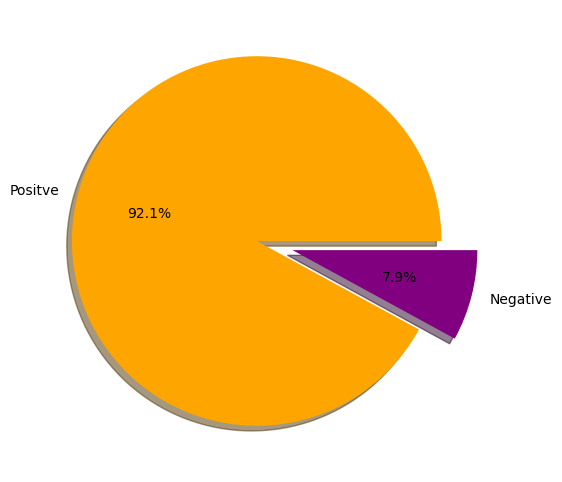

In [12]:
#pie chart of postive and negative sentiment based on compound score
plt.figure(figsize=(10,6))
plt.pie(df['sentiment'].value_counts(),labels=['Positve','Negative'], 
        explode=[0, 0.2],shadow = True, colors=['orange','purple'],autopct='%1.1f%%')

*<span style="color:orange">Inferences: There is clear evidence of imabalance in the dataset as there are more positive labels than negative labels.*